In [1]:
!pip install pyspark
!pip install tensorflow
!pip install keras
!apt install libopencv-dev python-opencv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python-opencv


In [2]:
import os
import zipfile
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from keras.models import load_model
import cv2
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt


In [3]:
spark = SparkSession.builder.appName("image_processing").getOrCreate()


In [4]:
from google.colab import files

uploaded_files = files.upload()

In [5]:
file_list = [file for file in uploaded_files.keys()]  

In [6]:

with zipfile.ZipFile('10000.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

image_files = []

for dirpath, dirs, files in os.walk("/content/10000"):
    for filename in files:
        if filename.endswith(".jpg"):
            fname = os.path.join(dirpath,filename)
            image_files.append(fname) # add the .png files to the list

if len(image_files) > 0:
    print(f"{len(image_files)} '.jpg' files found.")
else:
    print("No '.jpg' files found.")

10000 '.jpg' files found.


In [7]:
df = spark.createDataFrame([(t,) for t in image_files], ["filePath"])


In [32]:
from pyspark.sql.functions import udf


def read_image(filepath):
    # reads in BGR format
    img_bgr = cv2.imread(filepath)
    # Convert to RGB format
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb.tolist()

In [33]:
udf_read_image = udf(read_image, "array<array<array<int>>>")


In [34]:
image_df = df.withColumn("image", udf_read_image(df["filePath"]))


In [35]:
labels = [int(os.path.basename(os.path.dirname(file))) for file in image_files]


In [37]:
image_df = image_df.withColumn("label", lit(labels))


In [38]:
y = to_categorical(labels, num_classes=10)

X_train, X_test, y_train, y_test = train_test_split(image_files, y, random_state=42, test_size=0.2)


In [39]:
def load_images(image_files):
    images = []
    for file in image_files:
        # Read the image using OpenCV
        img = cv2.imread(str(file))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (32, 32))
            # Normalize the pixel values to the range of 0-1
            img_normalized = img_resized / 255.0
            # Append normalized image to the list
            images.append(img_normalized)
    return np.array(images)

In [40]:
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


X_train_paths = X_train
X_test_paths = X_test

X_train = load_images(X_train_paths)
X_test = load_images(X_test_paths)

# Reshape the input data
X_train = np.reshape(X_train, (-1, 32, 32, 3))
X_test = np.reshape(X_test, (-1, 32, 32, 3))

# Construct the VGG19 model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

y_train = y_train[:X_train.shape[0]]

datagen.fit(X_train)

y_train = y_train[:X_train.shape[0]]

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    epochs=15,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/15
63/63 [==============================] - 1379s 22s/step - loss: 2.1866 - accuracy: 0.3009 - val_loss: 1.7363 - val_accuracy: 0.4290
Epoch 2/15
63/63 [==============================] - 1368s 22s/step - loss: 1.3628 - accuracy: 0.6034 - val_loss: 0.7819 - val_accuracy: 0.8040
Epoch 3/15
63/63 [==============================] - 1337s 21s/step - loss: 0.9040 - accuracy: 0.7664 - val_loss: 0.7933 - val_accuracy: 0.7880
Epoch 4/15
63/63 [==============================] - 1327s 21s/step - loss: 0.6329 - accuracy: 0.8555 - val_loss: 0.4227 - val_accuracy: 0.9205
Epoch 5/15
63/63 [==============================] - 1327s 21s/step - loss: 0.4775 - accuracy: 0.9028 - val_loss: 0.5855 - val_accuracy: 0.8525
Epoch 6/15
63/63 [==============================] - 1347s 21s/step - loss: 0.4473 - accuracy: 0.9109 - val_loss: 0.3674 - val_accuracy: 0.9330
Epoch 7/15
63/63 [==============================] - 1333s 21s/step - loss: 0.3907 - accuracy: 0.9279 - val_loss: 0.3042 - val_accuracy: 0.9595

In [41]:
model.save("model.h5")

In [42]:
score = model.evaluate(X_test, y_test)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

63/63 [==============================] - 32s 511ms/step - loss: 0.2762 - accuracy: 0.9565
Test Loss: 0.2761741280555725
Test Accuracy: 0.9564999938011169


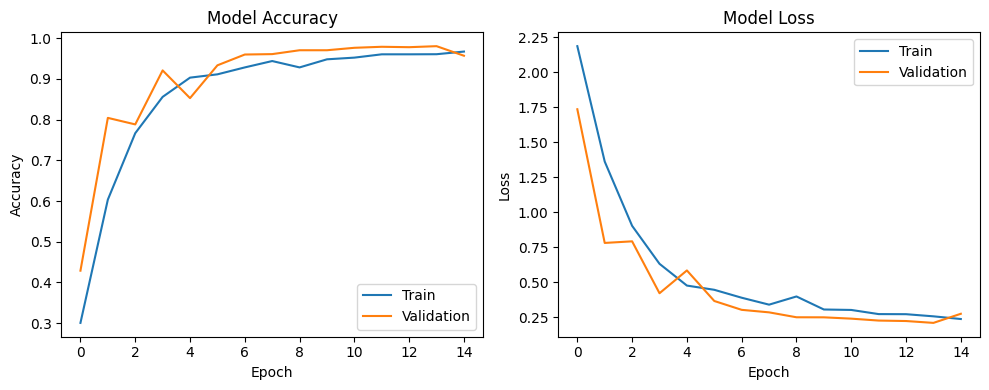

In [43]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [55]:
def predict_numbers(directory, model):
    image_files = []

    for dirpath, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".jpg"):
                filepath = os.path.join(dirpath, filename)
                image_files.append(filepath)

    images = load_images(image_files)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

In [58]:
with zipfile.ZipFile('Spark Digits.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

image_files = []

# Walk through each directory in the unzipped folder
for dirpath, dirs, files in os.walk("/content/Spark Digits"):
    for filename in files:
        if filename.endswith(".jpg"):
            fname = os.path.join(dirpath,filename)
            image_files.append(fname) # add the .png files to the list

if len(image_files) > 0:
    print(f"{len(image_files)} '.jpg' files found.")
else:
    print("No '.jpg' files found.")

No '.jpg' files found.


In [59]:
directory = "/content/Spark Digits"

# Load the trained model
model = load_model("model.h5")

# Predict the labels
predicted_labels = predict_numbers(directory, model)
print("Predicted Labels:", predicted_labels)

1/1 [==============================] - 0s 317ms/step
Predicted Labels: [7 3 7 3 9 5 0]


In [65]:
ground_truth_labels = [7, 3, 7, 3, 9, 5, 8]  # Replace with the actual ground truth labels

# Compare the predicted labels with the ground truth labels
correct_predictions = np.sum(np.array(predicted_labels) == np.array(ground_truth_labels))
accuracy = correct_predictions / len(ground_truth_labels)
print("Accuracy:", accuracy*100,"%")

Accuracy: 85.71428571428571 %
